In [13]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding='same')
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout1d(p=0.5)
        
        # calculate the in_features
        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 1 (features), 40 (sequence length)]
        x = self.conv1d(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling\
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [15]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/processed_data/{i}_table_train.npy')
        temp_val = np.load(f'../data/processed_data/{i}_table_val.npy')
        temp_test = np.load(f'../data/processed_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [17]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [18]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_final.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_final.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [19]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [20]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_final.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_final.png", bbox_inches='tight')
    plt.show()

In [21]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 55/55 [00:01<00:00, 28.86it/s]


Train: Epoch 0: Loss 2.3304290771484375, Accuracy 0.09284607438016529
Eval: Epoch 0: Loss 2.3027379512786865, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 36.74it/s]


Train: Epoch 1: Loss 2.3158514499664307, Accuracy 0.09656508264462811
Eval: Epoch 1: Loss 2.303602457046509, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 37.62it/s]


Train: Epoch 2: Loss 2.316525459289551, Accuracy 0.10578512396694215
Eval: Epoch 2: Loss 2.302854061126709, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 37.88it/s]


Train: Epoch 3: Loss 2.31941294670105, Accuracy 0.09359504132231404
Eval: Epoch 3: Loss 2.3017234802246094, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 38.33it/s]


Train: Epoch 4: Loss 2.308135509490967, Accuracy 0.10480371900826448
Eval: Epoch 4: Loss 2.301691770553589, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 38.43it/s]


Train: Epoch 5: Loss 2.3074986934661865, Accuracy 0.1028409090909091
Eval: Epoch 5: Loss 2.3010995388031006, Accuracy 0.119140625


100%|██████████| 55/55 [00:01<00:00, 39.68it/s]


Train: Epoch 6: Loss 2.308011770248413, Accuracy 0.09824380165289257
Eval: Epoch 6: Loss 2.3008344173431396, Accuracy 0.1244140625


100%|██████████| 55/55 [00:01<00:00, 39.31it/s]


Train: Epoch 7: Loss 2.305835008621216, Accuracy 0.10276342975206612
Eval: Epoch 7: Loss 2.3007545471191406, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 8: Loss 2.3029210567474365, Accuracy 0.1059142561983471
Eval: Epoch 8: Loss 2.3003921508789062, Accuracy 0.1068359375


100%|██████████| 55/55 [00:01<00:00, 38.65it/s]


Train: Epoch 9: Loss 2.3045010566711426, Accuracy 0.10415805785123966
Eval: Epoch 9: Loss 2.301448106765747, Accuracy 0.1171875


100%|██████████| 55/55 [00:01<00:00, 38.52it/s]


Train: Epoch 10: Loss 2.302062511444092, Accuracy 0.10945247933884297
Eval: Epoch 10: Loss 2.3009889125823975, Accuracy 0.1119140625


100%|██████████| 55/55 [00:01<00:00, 38.84it/s]


Train: Epoch 11: Loss 2.3003695011138916, Accuracy 0.11443698347107438
Eval: Epoch 11: Loss 2.300689935684204, Accuracy 0.1244140625


100%|██████████| 55/55 [00:01<00:00, 39.06it/s]


Train: Epoch 12: Loss 2.3023557662963867, Accuracy 0.11895661157024794
Eval: Epoch 12: Loss 2.3005807399749756, Accuracy 0.1146484375


100%|██████████| 55/55 [00:01<00:00, 39.43it/s]


Train: Epoch 13: Loss 2.3019285202026367, Accuracy 0.10914256198347108
Eval: Epoch 13: Loss 2.300372838973999, Accuracy 0.1201171875


100%|██████████| 55/55 [00:01<00:00, 39.43it/s]


Train: Epoch 14: Loss 2.303215265274048, Accuracy 0.11141528925619835
Eval: Epoch 14: Loss 2.3007919788360596, Accuracy 0.1111328125


100%|██████████| 55/55 [00:01<00:00, 37.62it/s]


Train: Epoch 15: Loss 2.302006959915161, Accuracy 0.10632747933884297
Eval: Epoch 15: Loss 2.301151990890503, Accuracy 0.11171875


100%|██████████| 55/55 [00:01<00:00, 39.09it/s]


Train: Epoch 16: Loss 2.299694776535034, Accuracy 0.1159349173553719
Eval: Epoch 16: Loss 2.3013343811035156, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 37.77it/s]


Train: Epoch 17: Loss 2.29890513420105, Accuracy 0.11410123966942148
Eval: Epoch 17: Loss 2.3009557723999023, Accuracy 0.11640625


100%|██████████| 55/55 [00:01<00:00, 37.52it/s]


Train: Epoch 18: Loss 2.303117513656616, Accuracy 0.10857438016528925
Eval: Epoch 18: Loss 2.301030158996582, Accuracy 0.1126953125


100%|██████████| 55/55 [00:01<00:00, 39.43it/s]


Train: Epoch 19: Loss 2.2967255115509033, Accuracy 0.12520661157024793
Eval: Epoch 19: Loss 2.3007984161376953, Accuracy 0.1138671875


100%|██████████| 55/55 [00:01<00:00, 38.46it/s]


Train: Epoch 20: Loss 2.298816680908203, Accuracy 0.11665805785123967
Eval: Epoch 20: Loss 2.299839496612549, Accuracy 0.121875


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 21: Loss 2.2986104488372803, Accuracy 0.11686466942148761
Eval: Epoch 21: Loss 2.300750255584717, Accuracy 0.1173828125


100%|██████████| 55/55 [00:01<00:00, 38.79it/s]


Train: Epoch 22: Loss 2.2992827892303467, Accuracy 0.11004648760330579
Eval: Epoch 22: Loss 2.300096273422241, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 38.04it/s]


Train: Epoch 23: Loss 2.2980141639709473, Accuracy 0.11869834710743801
Eval: Epoch 23: Loss 2.3005244731903076, Accuracy 0.1140625


100%|██████████| 55/55 [00:01<00:00, 38.52it/s]


Train: Epoch 24: Loss 2.2970128059387207, Accuracy 0.11115702479338842
Eval: Epoch 24: Loss 2.3003129959106445, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 25: Loss 2.2993507385253906, Accuracy 0.11727789256198347
Eval: Epoch 25: Loss 2.300410747528076, Accuracy 0.113671875


100%|██████████| 55/55 [00:01<00:00, 38.90it/s]


Train: Epoch 26: Loss 2.2985682487487793, Accuracy 0.11528925619834711
Eval: Epoch 26: Loss 2.300342321395874, Accuracy 0.11796875


100%|██████████| 55/55 [00:01<00:00, 39.65it/s]


Train: Epoch 27: Loss 2.2997944355010986, Accuracy 0.11430785123966943
Eval: Epoch 27: Loss 2.3005807399749756, Accuracy 0.11640625


100%|██████████| 55/55 [00:01<00:00, 39.97it/s]


Train: Epoch 28: Loss 2.2973320484161377, Accuracy 0.11203512396694215
Eval: Epoch 28: Loss 2.3000121116638184, Accuracy 0.1208984375


100%|██████████| 55/55 [00:01<00:00, 38.84it/s]


Train: Epoch 29: Loss 2.2973721027374268, Accuracy 0.10304752066115704
Eval: Epoch 29: Loss 2.3008270263671875, Accuracy 0.114453125


100%|██████████| 55/55 [00:01<00:00, 38.73it/s]


Train: Epoch 30: Loss 2.2953953742980957, Accuracy 0.11794938016528926
Eval: Epoch 30: Loss 2.3004331588745117, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 39.26it/s]


Train: Epoch 31: Loss 2.2969794273376465, Accuracy 0.12352789256198347
Eval: Epoch 31: Loss 2.2998406887054443, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 39.68it/s]


Train: Epoch 32: Loss 2.297808885574341, Accuracy 0.1165805785123967
Eval: Epoch 32: Loss 2.300438642501831, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 39.15it/s]


Train: Epoch 33: Loss 2.2928075790405273, Accuracy 0.12391528925619835
Eval: Epoch 33: Loss 2.301492929458618, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 37.83it/s]


Train: Epoch 34: Loss 2.292994737625122, Accuracy 0.12533574380165288
Eval: Epoch 34: Loss 2.301255464553833, Accuracy 0.1078125


100%|██████████| 55/55 [00:01<00:00, 39.86it/s]


Train: Epoch 35: Loss 2.2953062057495117, Accuracy 0.12665289256198348
Eval: Epoch 35: Loss 2.3029258251190186, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 39.48it/s]


Train: Epoch 36: Loss 2.295229434967041, Accuracy 0.11508264462809917
Eval: Epoch 36: Loss 2.3030872344970703, Accuracy 0.1109375


100%|██████████| 55/55 [00:01<00:00, 37.09it/s]


Train: Epoch 37: Loss 2.291078805923462, Accuracy 0.12809917355371903
Eval: Epoch 37: Loss 2.303720474243164, Accuracy 0.1140625


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 38: Loss 2.295027256011963, Accuracy 0.11939566115702478
Eval: Epoch 38: Loss 2.3033480644226074, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 35.92it/s]


Train: Epoch 39: Loss 2.2967398166656494, Accuracy 0.11572830578512397
Eval: Epoch 39: Loss 2.3040640354156494, Accuracy 0.1126953125


100%|██████████| 55/55 [00:01<00:00, 38.62it/s]


Train: Epoch 40: Loss 2.2956454753875732, Accuracy 0.12541322314049586
Eval: Epoch 40: Loss 2.304337978363037, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 38.19it/s]


Train: Epoch 41: Loss 2.2936549186706543, Accuracy 0.12453512396694215
Eval: Epoch 41: Loss 2.3046114444732666, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 42: Loss 2.293112277984619, Accuracy 0.12339876033057852
Eval: Epoch 42: Loss 2.3048243522644043, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 43: Loss 2.292343854904175, Accuracy 0.13099173553719007
Eval: Epoch 43: Loss 2.3057444095611572, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 38.98it/s]


Train: Epoch 44: Loss 2.2917051315307617, Accuracy 0.12636880165289255
Eval: Epoch 44: Loss 2.306424617767334, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 38.92it/s]


Train: Epoch 45: Loss 2.2862565517425537, Accuracy 0.13496900826446281
Eval: Epoch 45: Loss 2.30653977394104, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 37.39it/s]


Train: Epoch 46: Loss 2.291773557662964, Accuracy 0.1302944214876033
Eval: Epoch 46: Loss 2.3062424659729004, Accuracy 0.1080078125


100%|██████████| 55/55 [00:01<00:00, 37.09it/s]


Train: Epoch 47: Loss 2.2908575534820557, Accuracy 0.12889979338842975
Eval: Epoch 47: Loss 2.3068244457244873, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 36.23it/s]


Train: Epoch 48: Loss 2.2897229194641113, Accuracy 0.12536157024793387
Eval: Epoch 48: Loss 2.307173728942871, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 38.01it/s]


Train: Epoch 49: Loss 2.289095878601074, Accuracy 0.12944214876033058
Eval: Epoch 49: Loss 2.308570384979248, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 33.87it/s]


Train: Epoch 50: Loss 2.2870607376098633, Accuracy 0.1349948347107438
Eval: Epoch 50: Loss 2.3093178272247314, Accuracy 0.1076171875


100%|██████████| 55/55 [00:01<00:00, 34.18it/s]


Train: Epoch 51: Loss 2.2884507179260254, Accuracy 0.12520661157024793
Eval: Epoch 51: Loss 2.308212995529175, Accuracy 0.1134765625


100%|██████████| 55/55 [00:01<00:00, 35.53it/s]


Train: Epoch 52: Loss 2.2866954803466797, Accuracy 0.1346074380165289
Eval: Epoch 52: Loss 2.308201551437378, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 35.67it/s]


Train: Epoch 53: Loss 2.28656268119812, Accuracy 0.1290289256198347
Eval: Epoch 53: Loss 2.3084967136383057, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 36.09it/s]


Train: Epoch 54: Loss 2.2870352268218994, Accuracy 0.1327479338842975
Eval: Epoch 54: Loss 2.3102681636810303, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 35.85it/s]


Train: Epoch 55: Loss 2.2863054275512695, Accuracy 0.12990702479338842
Eval: Epoch 55: Loss 2.3094797134399414, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 56: Loss 2.284895181655884, Accuracy 0.13868801652892562
Eval: Epoch 56: Loss 2.308863878250122, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 35.99it/s]


Train: Epoch 57: Loss 2.2822680473327637, Accuracy 0.13078512396694214
Eval: Epoch 57: Loss 2.3097264766693115, Accuracy 0.1109375


100%|██████████| 55/55 [00:01<00:00, 36.45it/s]


Train: Epoch 58: Loss 2.284536123275757, Accuracy 0.13290289256198348
Eval: Epoch 58: Loss 2.3101274967193604, Accuracy 0.1125


100%|██████████| 55/55 [00:01<00:00, 35.69it/s]


Train: Epoch 59: Loss 2.2843387126922607, Accuracy 0.13205061983471075
Eval: Epoch 59: Loss 2.310239791870117, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 35.26it/s]


Train: Epoch 60: Loss 2.2842202186584473, Accuracy 0.14150309917355372
Eval: Epoch 60: Loss 2.3122646808624268, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 36.57it/s]


Train: Epoch 61: Loss 2.2796268463134766, Accuracy 0.13742252066115704
Eval: Epoch 61: Loss 2.312678098678589, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 36.42it/s]


Train: Epoch 62: Loss 2.2819228172302246, Accuracy 0.14096074380165288
Eval: Epoch 62: Loss 2.3129191398620605, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 36.23it/s]


Train: Epoch 63: Loss 2.280916929244995, Accuracy 0.14455061983471074
Eval: Epoch 63: Loss 2.3137423992156982, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 36.54it/s]


Train: Epoch 64: Loss 2.2759156227111816, Accuracy 0.14894111570247934
Eval: Epoch 64: Loss 2.3160452842712402, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 36.26it/s]


Train: Epoch 65: Loss 2.2805867195129395, Accuracy 0.1485020661157025
Eval: Epoch 65: Loss 2.314077138900757, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 36.59it/s]


Train: Epoch 66: Loss 2.2784934043884277, Accuracy 0.1381198347107438
Eval: Epoch 66: Loss 2.3141214847564697, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 36.23it/s]


Train: Epoch 67: Loss 2.2770285606384277, Accuracy 0.14625516528925622
Eval: Epoch 67: Loss 2.3136653900146484, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 36.02it/s]


Train: Epoch 68: Loss 2.2754757404327393, Accuracy 0.1443698347107438
Eval: Epoch 68: Loss 2.3155713081359863, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 35.95it/s]


Train: Epoch 69: Loss 2.274984121322632, Accuracy 0.14625516528925622
Eval: Epoch 69: Loss 2.3173303604125977, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 36.76it/s]


Train: Epoch 70: Loss 2.2805910110473633, Accuracy 0.1355888429752066
Eval: Epoch 70: Loss 2.3170785903930664, Accuracy 0.1111328125


100%|██████████| 55/55 [00:01<00:00, 36.04it/s]


Train: Epoch 71: Loss 2.275148630142212, Accuracy 0.14284607438016528
Eval: Epoch 71: Loss 2.31537127494812, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 36.16it/s]


Train: Epoch 72: Loss 2.273061513900757, Accuracy 0.15077479338842975
Eval: Epoch 72: Loss 2.3179874420166016, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 36.67it/s]


Train: Epoch 73: Loss 2.274587392807007, Accuracy 0.14488636363636365
Eval: Epoch 73: Loss 2.318103551864624, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 36.23it/s]


Train: Epoch 74: Loss 2.2711687088012695, Accuracy 0.1456869834710744
Eval: Epoch 74: Loss 2.317857265472412, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 36.45it/s]


Train: Epoch 75: Loss 2.2687699794769287, Accuracy 0.1513171487603306
Eval: Epoch 75: Loss 2.318922519683838, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 36.07it/s]


Train: Epoch 76: Loss 2.2706217765808105, Accuracy 0.14139979338842976
Eval: Epoch 76: Loss 2.317258834838867, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 36.40it/s]


Train: Epoch 77: Loss 2.27325177192688, Accuracy 0.1390754132231405
Eval: Epoch 77: Loss 2.3191123008728027, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 36.02it/s]


Train: Epoch 78: Loss 2.269529342651367, Accuracy 0.14085743801652892
Eval: Epoch 78: Loss 2.3199362754821777, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 36.30it/s]


Train: Epoch 79: Loss 2.2679669857025146, Accuracy 0.15418388429752067
Eval: Epoch 79: Loss 2.3214776515960693, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 36.32it/s]


Train: Epoch 80: Loss 2.2661101818084717, Accuracy 0.15167871900826446
Eval: Epoch 80: Loss 2.3218517303466797, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 35.99it/s]


Train: Epoch 81: Loss 2.268681049346924, Accuracy 0.14424070247933884
Eval: Epoch 81: Loss 2.322422742843628, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 36.45it/s]


Train: Epoch 82: Loss 2.2602908611297607, Accuracy 0.15914256198347107
Eval: Epoch 82: Loss 2.3217458724975586, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 36.23it/s]


Train: Epoch 83: Loss 2.2647552490234375, Accuracy 0.15857438016528924
Eval: Epoch 83: Loss 2.322661876678467, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 36.59it/s]


Train: Epoch 84: Loss 2.2591116428375244, Accuracy 0.16043388429752067
Eval: Epoch 84: Loss 2.321648120880127, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.68it/s]


Train: Epoch 85: Loss 2.2647294998168945, Accuracy 0.14194214876033057
Eval: Epoch 85: Loss 2.322103500366211, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 36.30it/s]


Train: Epoch 86: Loss 2.259908676147461, Accuracy 0.1493801652892562
Eval: Epoch 86: Loss 2.3213279247283936, Accuracy 0.1076171875


100%|██████████| 55/55 [00:01<00:00, 33.09it/s]


Train: Epoch 87: Loss 2.2582297325134277, Accuracy 0.1514721074380165
Eval: Epoch 87: Loss 2.3231561183929443, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 33.76it/s]


Train: Epoch 88: Loss 2.2555091381073, Accuracy 0.15715392561983468
Eval: Epoch 88: Loss 2.3243157863616943, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 35.80it/s]


Train: Epoch 89: Loss 2.2599451541900635, Accuracy 0.15872933884297522
Eval: Epoch 89: Loss 2.3228402137756348, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 35.94it/s]


Train: Epoch 90: Loss 2.2566215991973877, Accuracy 0.15684400826446282
Eval: Epoch 90: Loss 2.324983596801758, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 35.60it/s]


Train: Epoch 91: Loss 2.2560791969299316, Accuracy 0.14981921487603306
Eval: Epoch 91: Loss 2.3242013454437256, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 35.07it/s]


Train: Epoch 92: Loss 2.2519278526306152, Accuracy 0.15537190082644628
Eval: Epoch 92: Loss 2.326019525527954, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 35.87it/s]


Train: Epoch 93: Loss 2.2497289180755615, Accuracy 0.16304235537190082
Eval: Epoch 93: Loss 2.327057361602783, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 36.17it/s]


Train: Epoch 94: Loss 2.2546558380126953, Accuracy 0.15870351239669422
Eval: Epoch 94: Loss 2.327526569366455, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 35.39it/s]


Train: Epoch 95: Loss 2.251697301864624, Accuracy 0.1611828512396694
Eval: Epoch 95: Loss 2.326601982116699, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 35.74it/s]


Train: Epoch 96: Loss 2.2465360164642334, Accuracy 0.16854338842975206
Eval: Epoch 96: Loss 2.3302416801452637, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 36.21it/s]


Train: Epoch 97: Loss 2.2440335750579834, Accuracy 0.16541838842975207
Eval: Epoch 97: Loss 2.3311948776245117, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 35.99it/s]


Train: Epoch 98: Loss 2.244000196456909, Accuracy 0.16435950413223138
Eval: Epoch 98: Loss 2.331697463989258, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 33.29it/s]


Train: Epoch 99: Loss 2.2450473308563232, Accuracy 0.16771694214876035
Eval: Epoch 99: Loss 2.333883047103882, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 33.62it/s]


Train: Epoch 100: Loss 2.2455577850341797, Accuracy 0.16040805785123965
Eval: Epoch 100: Loss 2.333693504333496, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 34.29it/s]


Train: Epoch 101: Loss 2.2386691570281982, Accuracy 0.17998450413223138
Eval: Epoch 101: Loss 2.3335275650024414, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 35.64it/s]


Train: Epoch 102: Loss 2.2409474849700928, Accuracy 0.16606404958677684
Eval: Epoch 102: Loss 2.3354549407958984, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 35.94it/s]


Train: Epoch 103: Loss 2.234968423843384, Accuracy 0.1827995867768595
Eval: Epoch 103: Loss 2.335639715194702, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 35.19it/s]


Train: Epoch 104: Loss 2.2374305725097656, Accuracy 0.17629132231404956
Eval: Epoch 104: Loss 2.335306406021118, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 35.39it/s]


Train: Epoch 105: Loss 2.2368407249450684, Accuracy 0.1681043388429752
Eval: Epoch 105: Loss 2.3368961811065674, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 35.35it/s]


Train: Epoch 106: Loss 2.2414932250976562, Accuracy 0.16611570247933885
Eval: Epoch 106: Loss 2.339195728302002, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 35.64it/s]


Train: Epoch 107: Loss 2.229940891265869, Accuracy 0.1756456611570248
Eval: Epoch 107: Loss 2.339702606201172, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 36.28it/s]


Train: Epoch 108: Loss 2.2328743934631348, Accuracy 0.18013946280991736
Eval: Epoch 108: Loss 2.339959144592285, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 35.74it/s]


Train: Epoch 109: Loss 2.2284634113311768, Accuracy 0.1771952479338843
Eval: Epoch 109: Loss 2.3375327587127686, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 35.58it/s]


Train: Epoch 110: Loss 2.225966215133667, Accuracy 0.17435433884297522
Eval: Epoch 110: Loss 2.3402256965637207, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 35.92it/s]


Train: Epoch 111: Loss 2.227067708969116, Accuracy 0.17396694214876032
Eval: Epoch 111: Loss 2.3424644470214844, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 35.75it/s]


Train: Epoch 112: Loss 2.2263755798339844, Accuracy 0.17357954545454546
Eval: Epoch 112: Loss 2.3434226512908936, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 35.39it/s]


Train: Epoch 113: Loss 2.2240588665008545, Accuracy 0.17644628099173554
Eval: Epoch 113: Loss 2.3421406745910645, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 34.68it/s]


Train: Epoch 114: Loss 2.221545934677124, Accuracy 0.17422520661157023
Eval: Epoch 114: Loss 2.3437185287475586, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 35.37it/s]


Train: Epoch 115: Loss 2.2250709533691406, Accuracy 0.1800103305785124
Eval: Epoch 115: Loss 2.344250202178955, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 34.83it/s]


Train: Epoch 116: Loss 2.2202188968658447, Accuracy 0.18700929752066114
Eval: Epoch 116: Loss 2.3458805084228516, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 35.92it/s]


Train: Epoch 117: Loss 2.2103991508483887, Accuracy 0.18184400826446281
Eval: Epoch 117: Loss 2.3488686084747314, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 35.46it/s]


Train: Epoch 118: Loss 2.214364767074585, Accuracy 0.18143078512396693
Eval: Epoch 118: Loss 2.3505008220672607, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 35.64it/s]


Train: Epoch 119: Loss 2.216155767440796, Accuracy 0.17440599173553717
Eval: Epoch 119: Loss 2.352492570877075, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 31.18it/s]


Train: Epoch 120: Loss 2.211141347885132, Accuracy 0.18212809917355371
Eval: Epoch 120: Loss 2.3511600494384766, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 121: Loss 2.2159922122955322, Accuracy 0.18675103305785123
Eval: Epoch 121: Loss 2.3537673950195312, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 35.28it/s]


Train: Epoch 122: Loss 2.207015037536621, Accuracy 0.2012396694214876
Eval: Epoch 122: Loss 2.3504536151885986, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 35.55it/s]


Train: Epoch 123: Loss 2.203571319580078, Accuracy 0.18840392561983468
Eval: Epoch 123: Loss 2.352835178375244, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 34.99it/s]


Train: Epoch 124: Loss 2.2075579166412354, Accuracy 0.18757747933884297
Eval: Epoch 124: Loss 2.3538782596588135, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 35.26it/s]


Train: Epoch 125: Loss 2.1983866691589355, Accuracy 0.190650826446281
Eval: Epoch 125: Loss 2.354444980621338, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 36.09it/s]


Train: Epoch 126: Loss 2.2017111778259277, Accuracy 0.18799070247933886
Eval: Epoch 126: Loss 2.357548952102661, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 35.25it/s]


Train: Epoch 127: Loss 2.204292058944702, Accuracy 0.18814566115702477
Eval: Epoch 127: Loss 2.356811046600342, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 35.48it/s]


Train: Epoch 128: Loss 2.2026779651641846, Accuracy 0.19351756198347106
Eval: Epoch 128: Loss 2.3575611114501953, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 35.35it/s]


Train: Epoch 129: Loss 2.1998817920684814, Accuracy 0.19238119834710743
Eval: Epoch 129: Loss 2.3599560260772705, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 35.69it/s]


Train: Epoch 130: Loss 2.1916778087615967, Accuracy 0.1963068181818182
Eval: Epoch 130: Loss 2.35896635055542, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 35.85it/s]


Train: Epoch 131: Loss 2.1927852630615234, Accuracy 0.1912190082644628
Eval: Epoch 131: Loss 2.3602564334869385, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 35.71it/s]


Train: Epoch 132: Loss 2.195617914199829, Accuracy 0.1933626033057851
Eval: Epoch 132: Loss 2.3586819171905518, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 35.76it/s]


Train: Epoch 133: Loss 2.1900553703308105, Accuracy 0.19426652892561985
Eval: Epoch 133: Loss 2.363288640975952, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 34.83it/s]


Train: Epoch 134: Loss 2.1884546279907227, Accuracy 0.20402892561983468
Eval: Epoch 134: Loss 2.364152669906616, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 135: Loss 2.1936874389648438, Accuracy 0.19491219008264463
Eval: Epoch 135: Loss 2.3618016242980957, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 35.69it/s]


Train: Epoch 136: Loss 2.1840052604675293, Accuracy 0.20485537190082645
Eval: Epoch 136: Loss 2.362818956375122, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 35.97it/s]


Train: Epoch 137: Loss 2.187384843826294, Accuracy 0.19821797520661158
Eval: Epoch 137: Loss 2.3659236431121826, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 35.39it/s]


Train: Epoch 138: Loss 2.1830341815948486, Accuracy 0.20823863636363638
Eval: Epoch 138: Loss 2.3679146766662598, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 35.05it/s]


Train: Epoch 139: Loss 2.1858325004577637, Accuracy 0.19493801652892562
Eval: Epoch 139: Loss 2.369302988052368, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 35.37it/s]


Train: Epoch 140: Loss 2.1747312545776367, Accuracy 0.20658574380165287
Eval: Epoch 140: Loss 2.3686280250549316, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 35.42it/s]


Train: Epoch 141: Loss 2.179685592651367, Accuracy 0.20612086776859503
Eval: Epoch 141: Loss 2.3693392276763916, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 35.10it/s]


Train: Epoch 142: Loss 2.1784121990203857, Accuracy 0.19395661157024793
Eval: Epoch 142: Loss 2.3710319995880127, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 35.60it/s]


Train: Epoch 143: Loss 2.173534870147705, Accuracy 0.20699896694214875
Eval: Epoch 143: Loss 2.3779101371765137, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 35.74it/s]


Train: Epoch 144: Loss 2.1758151054382324, Accuracy 0.20377066115702477
Eval: Epoch 144: Loss 2.375133752822876, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 34.90it/s]


Train: Epoch 145: Loss 2.1790215969085693, Accuracy 0.20470041322314048
Eval: Epoch 145: Loss 2.3716530799865723, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 35.71it/s]


Train: Epoch 146: Loss 2.1693999767303467, Accuracy 0.21454028925619834
Eval: Epoch 146: Loss 2.3736371994018555, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 35.17it/s]


Train: Epoch 147: Loss 2.164858341217041, Accuracy 0.20204028925619832
Eval: Epoch 147: Loss 2.3725459575653076, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 31.11it/s]


Train: Epoch 148: Loss 2.169565439224243, Accuracy 0.20260847107438015
Eval: Epoch 148: Loss 2.375483989715576, Accuracy 0.0845703125


100%|██████████| 55/55 [00:01<00:00, 34.83it/s]


Train: Epoch 149: Loss 2.163475751876831, Accuracy 0.2065082644628099
Eval: Epoch 149: Loss 2.3735198974609375, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 35.08it/s]


Train: Epoch 150: Loss 2.1624460220336914, Accuracy 0.21523760330578512
Eval: Epoch 150: Loss 2.3782215118408203, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 35.35it/s]


Train: Epoch 151: Loss 2.1647908687591553, Accuracy 0.21650309917355373
Eval: Epoch 151: Loss 2.3782460689544678, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 34.48it/s]


Train: Epoch 152: Loss 2.158950090408325, Accuracy 0.21552169421487602
Eval: Epoch 152: Loss 2.3769047260284424, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 153: Loss 2.154710292816162, Accuracy 0.2256198347107438
Eval: Epoch 153: Loss 2.381638765335083, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 35.14it/s]


Train: Epoch 154: Loss 2.1518502235412598, Accuracy 0.21887913223140498
Eval: Epoch 154: Loss 2.3822710514068604, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 35.95it/s]


Train: Epoch 155: Loss 2.145033597946167, Accuracy 0.22143595041322314
Eval: Epoch 155: Loss 2.386354923248291, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 156: Loss 2.1479268074035645, Accuracy 0.22476756198347106
Eval: Epoch 156: Loss 2.3826043605804443, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 35.42it/s]


Train: Epoch 157: Loss 2.158149242401123, Accuracy 0.215625
Eval: Epoch 157: Loss 2.386338710784912, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 35.60it/s]


Train: Epoch 158: Loss 2.144509792327881, Accuracy 0.22019628099173555
Eval: Epoch 158: Loss 2.3835158348083496, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 34.68it/s]


Train: Epoch 159: Loss 2.1488184928894043, Accuracy 0.21479855371900827
Eval: Epoch 159: Loss 2.386115789413452, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 34.83it/s]


Train: Epoch 160: Loss 2.13944673538208, Accuracy 0.23682851239669422
Eval: Epoch 160: Loss 2.385701894760132, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 34.83it/s]


Train: Epoch 161: Loss 2.1341559886932373, Accuracy 0.23068181818181818
Eval: Epoch 161: Loss 2.392686128616333, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 33.60it/s]


Train: Epoch 162: Loss 2.138960599899292, Accuracy 0.22786673553719008
Eval: Epoch 162: Loss 2.3951351642608643, Accuracy 0.0921875


100%|██████████| 55/55 [00:02<00:00, 25.29it/s]


Train: Epoch 163: Loss 2.1345505714416504, Accuracy 0.22696280991735537
Eval: Epoch 163: Loss 2.3952841758728027, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 37.15it/s]


Train: Epoch 164: Loss 2.138248920440674, Accuracy 0.22840909090909092
Eval: Epoch 164: Loss 2.394777297973633, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 37.24it/s]


Train: Epoch 165: Loss 2.130161762237549, Accuracy 0.2228047520661157
Eval: Epoch 165: Loss 2.394289016723633, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 36.80it/s]


Train: Epoch 166: Loss 2.1360647678375244, Accuracy 0.23068181818181818
Eval: Epoch 166: Loss 2.3975396156311035, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 35.60it/s]


Train: Epoch 167: Loss 2.1330325603485107, Accuracy 0.2315599173553719
Eval: Epoch 167: Loss 2.3975934982299805, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 34.55it/s]


Train: Epoch 168: Loss 2.1258890628814697, Accuracy 0.23638946280991738
Eval: Epoch 168: Loss 2.3957302570343018, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 33.35it/s]


Train: Epoch 169: Loss 2.1279921531677246, Accuracy 0.23044938016528924
Eval: Epoch 169: Loss 2.3933827877044678, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 34.35it/s]


Train: Epoch 170: Loss 2.125143527984619, Accuracy 0.24147727272727273
Eval: Epoch 170: Loss 2.3997888565063477, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 33.21it/s]


Train: Epoch 171: Loss 2.1235623359680176, Accuracy 0.23450413223140498
Eval: Epoch 171: Loss 2.3953075408935547, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 30.35it/s]


Train: Epoch 172: Loss 2.1195273399353027, Accuracy 0.23990185950413223
Eval: Epoch 172: Loss 2.3994319438934326, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 33.45it/s]


Train: Epoch 173: Loss 2.1215760707855225, Accuracy 0.22988119834710743
Eval: Epoch 173: Loss 2.401304006576538, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 33.66it/s]


Train: Epoch 174: Loss 2.1154651641845703, Accuracy 0.24266528925619832
Eval: Epoch 174: Loss 2.4016377925872803, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 33.60it/s]


Train: Epoch 175: Loss 2.1067299842834473, Accuracy 0.2440082644628099
Eval: Epoch 175: Loss 2.4006011486053467, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 34.03it/s]


Train: Epoch 176: Loss 2.1195974349975586, Accuracy 0.23308367768595042
Eval: Epoch 176: Loss 2.4035613536834717, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 34.12it/s]


Train: Epoch 177: Loss 2.1073038578033447, Accuracy 0.24390495867768594
Eval: Epoch 177: Loss 2.4049930572509766, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 34.02it/s]


Train: Epoch 178: Loss 2.1114444732666016, Accuracy 0.2434400826446281
Eval: Epoch 178: Loss 2.408569097518921, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 33.83it/s]


Train: Epoch 179: Loss 2.1085972785949707, Accuracy 0.25167871900826444
Eval: Epoch 179: Loss 2.408914089202881, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 33.81it/s]


Train: Epoch 180: Loss 2.104637384414673, Accuracy 0.24956095041322315
Eval: Epoch 180: Loss 2.412517786026001, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 34.11it/s]


Train: Epoch 181: Loss 2.1018238067626953, Accuracy 0.24865702479338841
Eval: Epoch 181: Loss 2.417055368423462, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 33.66it/s]


Train: Epoch 182: Loss 2.090747594833374, Accuracy 0.2552685950413223
Eval: Epoch 182: Loss 2.415403127670288, Accuracy 0.0837890625


100%|██████████| 55/55 [00:01<00:00, 33.63it/s]


Train: Epoch 183: Loss 2.100255012512207, Accuracy 0.24300103305785123
Eval: Epoch 183: Loss 2.413849353790283, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 33.68it/s]


Train: Epoch 184: Loss 2.103501319885254, Accuracy 0.240599173553719
Eval: Epoch 184: Loss 2.417621612548828, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 34.44it/s]


Train: Epoch 185: Loss 2.0963094234466553, Accuracy 0.2458935950413223
Eval: Epoch 185: Loss 2.414344310760498, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 34.08it/s]


Train: Epoch 186: Loss 2.093447685241699, Accuracy 0.23791322314049587
Eval: Epoch 186: Loss 2.41880464553833, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 34.42it/s]


Train: Epoch 187: Loss 2.097609043121338, Accuracy 0.2502066115702479
Eval: Epoch 187: Loss 2.4155895709991455, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 34.48it/s]


Train: Epoch 188: Loss 2.0869951248168945, Accuracy 0.26141528925619834
Eval: Epoch 188: Loss 2.417412042617798, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 34.37it/s]


Train: Epoch 189: Loss 2.0910937786102295, Accuracy 0.25586260330578514
Eval: Epoch 189: Loss 2.4283978939056396, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 33.50it/s]


Train: Epoch 190: Loss 2.08604097366333, Accuracy 0.25606921487603307
Eval: Epoch 190: Loss 2.4246394634246826, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 34.50it/s]


Train: Epoch 191: Loss 2.077179431915283, Accuracy 0.25950413223140495
Eval: Epoch 191: Loss 2.4201512336730957, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 29.64it/s]


Train: Epoch 192: Loss 2.0902841091156006, Accuracy 0.2566632231404959
Eval: Epoch 192: Loss 2.4224913120269775, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 33.52it/s]


Train: Epoch 193: Loss 2.0892128944396973, Accuracy 0.24620351239669422
Eval: Epoch 193: Loss 2.4281256198883057, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 194: Loss 2.0774855613708496, Accuracy 0.2553719008264463
Eval: Epoch 194: Loss 2.425446033477783, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 34.08it/s]


Train: Epoch 195: Loss 2.069977045059204, Accuracy 0.26730371900826444
Eval: Epoch 195: Loss 2.4342126846313477, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 33.93it/s]


Train: Epoch 196: Loss 2.0679030418395996, Accuracy 0.259375
Eval: Epoch 196: Loss 2.4330201148986816, Accuracy 0.08828125


100%|██████████| 55/55 [00:01<00:00, 34.37it/s]


Train: Epoch 197: Loss 2.066150426864624, Accuracy 0.2669938016528926
Eval: Epoch 197: Loss 2.4351978302001953, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 33.66it/s]


Train: Epoch 198: Loss 2.0684022903442383, Accuracy 0.2646177685950413
Eval: Epoch 198: Loss 2.432429313659668, Accuracy 0.086328125


100%|██████████| 55/55 [00:01<00:00, 34.33it/s]


Train: Epoch 199: Loss 2.070521354675293, Accuracy 0.2616477272727273
Eval: Epoch 199: Loss 2.43570613861084, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 34.11it/s]


Train: Epoch 200: Loss 2.0674853324890137, Accuracy 0.27776342975206614
Eval: Epoch 200: Loss 2.434451103210449, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 33.86it/s]


Train: Epoch 201: Loss 2.0605051517486572, Accuracy 0.2671487603305785
Eval: Epoch 201: Loss 2.434746026992798, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 33.68it/s]


Train: Epoch 202: Loss 2.0634958744049072, Accuracy 0.26110537190082644
Eval: Epoch 202: Loss 2.4336743354797363, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 33.88it/s]


Train: Epoch 203: Loss 2.0621070861816406, Accuracy 0.26355888429752067
Eval: Epoch 203: Loss 2.437690496444702, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 34.08it/s]


Train: Epoch 204: Loss 2.057772159576416, Accuracy 0.2717200413223141
Eval: Epoch 204: Loss 2.437863349914551, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 33.58it/s]


Train: Epoch 205: Loss 2.0554158687591553, Accuracy 0.278176652892562
Eval: Epoch 205: Loss 2.442370891571045, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 34.03it/s]


Train: Epoch 206: Loss 2.048403024673462, Accuracy 0.27923553719008265
Eval: Epoch 206: Loss 2.438723087310791, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 33.70it/s]


Train: Epoch 207: Loss 2.0480284690856934, Accuracy 0.27396694214876033
Eval: Epoch 207: Loss 2.4405367374420166, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 34.27it/s]


Train: Epoch 208: Loss 2.0469346046447754, Accuracy 0.27115185950413223
Eval: Epoch 208: Loss 2.4474527835845947, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 34.10it/s]


Train: Epoch 209: Loss 2.043614149093628, Accuracy 0.26887913223140497
Eval: Epoch 209: Loss 2.4406299591064453, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 32.58it/s]


Train: Epoch 210: Loss 2.04545259475708, Accuracy 0.26924070247933884
Eval: Epoch 210: Loss 2.447667360305786, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 30.32it/s]


Train: Epoch 211: Loss 2.036311388015747, Accuracy 0.2786673553719008
Eval: Epoch 211: Loss 2.453443765640259, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 33.07it/s]


Train: Epoch 212: Loss 2.0359718799591064, Accuracy 0.27611053719008266
Eval: Epoch 212: Loss 2.4481492042541504, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 34.10it/s]


Train: Epoch 213: Loss 2.0410287380218506, Accuracy 0.27915805785123965
Eval: Epoch 213: Loss 2.455280065536499, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 33.99it/s]


Train: Epoch 214: Loss 2.040553331375122, Accuracy 0.2722882231404959
Eval: Epoch 214: Loss 2.4504482746124268, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 33.51it/s]


Train: Epoch 215: Loss 2.034602642059326, Accuracy 0.2751549586776859
Eval: Epoch 215: Loss 2.4532790184020996, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 34.27it/s]


Train: Epoch 216: Loss 2.0324201583862305, Accuracy 0.27680785123966944
Eval: Epoch 216: Loss 2.4568512439727783, Accuracy 0.0853515625


100%|██████████| 55/55 [00:01<00:00, 34.14it/s]


Train: Epoch 217: Loss 2.024357795715332, Accuracy 0.2730888429752066
Eval: Epoch 217: Loss 2.460005044937134, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 34.40it/s]


Train: Epoch 218: Loss 2.029303789138794, Accuracy 0.28675103305785127
Eval: Epoch 218: Loss 2.4626920223236084, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.01it/s]


Train: Epoch 219: Loss 2.0240705013275146, Accuracy 0.28538223140495866
Eval: Epoch 219: Loss 2.4632983207702637, Accuracy 0.0853515625


100%|██████████| 55/55 [00:01<00:00, 33.70it/s]


Train: Epoch 220: Loss 2.0188467502593994, Accuracy 0.27685950413223137
Eval: Epoch 220: Loss 2.4683921337127686, Accuracy 0.085546875


100%|██████████| 55/55 [00:01<00:00, 33.70it/s]


Train: Epoch 221: Loss 2.0221521854400635, Accuracy 0.28083677685950414
Eval: Epoch 221: Loss 2.4648756980895996, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 222: Loss 2.0244059562683105, Accuracy 0.28551136363636365
Eval: Epoch 222: Loss 2.4665770530700684, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 34.10it/s]


Train: Epoch 223: Loss 2.018043041229248, Accuracy 0.28230888429752066
Eval: Epoch 223: Loss 2.4712095260620117, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 33.56it/s]


Train: Epoch 224: Loss 2.0162270069122314, Accuracy 0.28610537190082647
Eval: Epoch 224: Loss 2.4713449478149414, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 33.66it/s]


Train: Epoch 225: Loss 2.0111124515533447, Accuracy 0.2902117768595041
Eval: Epoch 225: Loss 2.4710185527801514, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 33.74it/s]


Train: Epoch 226: Loss 2.007650375366211, Accuracy 0.2997675619834711
Eval: Epoch 226: Loss 2.4693286418914795, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 33.60it/s]


Train: Epoch 227: Loss 2.0085830688476562, Accuracy 0.2894111570247934
Eval: Epoch 227: Loss 2.4728267192840576, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 228: Loss 2.0139245986938477, Accuracy 0.28744834710743805
Eval: Epoch 228: Loss 2.4736990928649902, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 229: Loss 2.0020346641540527, Accuracy 0.2957902892561984
Eval: Epoch 229: Loss 2.475985288619995, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 29.29it/s]


Train: Epoch 230: Loss 1.9988434314727783, Accuracy 0.29783057851239664
Eval: Epoch 230: Loss 2.480297803878784, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 33.35it/s]


Train: Epoch 231: Loss 2.0000510215759277, Accuracy 0.29945764462809915
Eval: Epoch 231: Loss 2.480883836746216, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 33.61it/s]


Train: Epoch 232: Loss 2.0009925365448, Accuracy 0.28192148760330576
Eval: Epoch 232: Loss 2.4802184104919434, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 33.78it/s]


Train: Epoch 233: Loss 1.9926663637161255, Accuracy 0.29375
Eval: Epoch 233: Loss 2.488347053527832, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 31.99it/s]


Train: Epoch 234: Loss 1.9982107877731323, Accuracy 0.29204545454545455
Eval: Epoch 234: Loss 2.483213186264038, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 33.37it/s]


Train: Epoch 235: Loss 1.9876987934112549, Accuracy 0.2995351239669421
Eval: Epoch 235: Loss 2.4826791286468506, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 33.49it/s]


Train: Epoch 236: Loss 1.9879741668701172, Accuracy 0.2995351239669421
Eval: Epoch 236: Loss 2.4790079593658447, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 33.27it/s]


Train: Epoch 237: Loss 1.99070143699646, Accuracy 0.30291838842975205
Eval: Epoch 237: Loss 2.4884533882141113, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 33.60it/s]


Train: Epoch 238: Loss 1.982589840888977, Accuracy 0.29762396694214877
Eval: Epoch 238: Loss 2.4877495765686035, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 33.37it/s]


Train: Epoch 239: Loss 1.9897297620773315, Accuracy 0.3006973140495868
Eval: Epoch 239: Loss 2.4845845699310303, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 33.80it/s]


Train: Epoch 240: Loss 1.9884936809539795, Accuracy 0.3048553719008264
Eval: Epoch 240: Loss 2.484954833984375, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 33.72it/s]


Train: Epoch 241: Loss 1.9779317378997803, Accuracy 0.2990960743801653
Eval: Epoch 241: Loss 2.490415096282959, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 33.35it/s]


Train: Epoch 242: Loss 1.97105073928833, Accuracy 0.3101239669421488
Eval: Epoch 242: Loss 2.495255708694458, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 33.66it/s]


Train: Epoch 243: Loss 1.9833418130874634, Accuracy 0.3045196280991736
Eval: Epoch 243: Loss 2.4969704151153564, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 244: Loss 1.9656310081481934, Accuracy 0.3136105371900827
Eval: Epoch 244: Loss 2.494858980178833, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 34.07it/s]


Train: Epoch 245: Loss 1.9789478778839111, Accuracy 0.3003099173553719
Eval: Epoch 245: Loss 2.492565155029297, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 246: Loss 1.960396647453308, Accuracy 0.3113378099173554
Eval: Epoch 246: Loss 2.498387098312378, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 33.37it/s]


Train: Epoch 247: Loss 1.9656184911727905, Accuracy 0.31335227272727273
Eval: Epoch 247: Loss 2.496779441833496, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 30.03it/s]


Train: Epoch 248: Loss 1.971779704093933, Accuracy 0.3047520661157025
Eval: Epoch 248: Loss 2.500584125518799, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 33.49it/s]


Train: Epoch 249: Loss 1.956215262413025, Accuracy 0.31701962809917356
Eval: Epoch 249: Loss 2.5022449493408203, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 33.82it/s]


Train: Epoch 250: Loss 1.9568507671356201, Accuracy 0.3162706611570248
Eval: Epoch 250: Loss 2.5075454711914062, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 34.16it/s]


Train: Epoch 251: Loss 1.9597679376602173, Accuracy 0.31265495867768595
Eval: Epoch 251: Loss 2.510317087173462, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 32.22it/s]


Train: Epoch 252: Loss 1.958631992340088, Accuracy 0.3110537190082645
Eval: Epoch 252: Loss 2.4998931884765625, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 31.37it/s]


Train: Epoch 253: Loss 1.9575796127319336, Accuracy 0.3119318181818182
Eval: Epoch 253: Loss 2.5089659690856934, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 31.32it/s]


Train: Epoch 254: Loss 1.9446563720703125, Accuracy 0.32745351239669424
Eval: Epoch 254: Loss 2.505528450012207, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 32.41it/s]


Train: Epoch 255: Loss 1.9431284666061401, Accuracy 0.32045454545454544
Eval: Epoch 255: Loss 2.5104269981384277, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 29.92it/s]


Train: Epoch 256: Loss 1.947839379310608, Accuracy 0.30547520661157024
Eval: Epoch 256: Loss 2.5122768878936768, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 30.34it/s]


Train: Epoch 257: Loss 1.9410412311553955, Accuracy 0.32254648760330573
Eval: Epoch 257: Loss 2.5091476440429688, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 30.29it/s]


Train: Epoch 258: Loss 1.956852674484253, Accuracy 0.3041064049586777
Eval: Epoch 258: Loss 2.516968250274658, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 30.32it/s]


Train: Epoch 259: Loss 1.9420702457427979, Accuracy 0.3256456611570248
Eval: Epoch 259: Loss 2.5068228244781494, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 31.88it/s]


Train: Epoch 260: Loss 1.936631679534912, Accuracy 0.31477272727272726
Eval: Epoch 260: Loss 2.5261776447296143, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 31.25it/s]


Train: Epoch 261: Loss 1.9303332567214966, Accuracy 0.32673037190082643
Eval: Epoch 261: Loss 2.5190324783325195, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 30.93it/s]


Train: Epoch 262: Loss 1.930686116218567, Accuracy 0.3270919421487603
Eval: Epoch 262: Loss 2.5166149139404297, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 31.02it/s]


Train: Epoch 263: Loss 1.9258792400360107, Accuracy 0.3298037190082645
Eval: Epoch 263: Loss 2.5212550163269043, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 30.76it/s]


Train: Epoch 264: Loss 1.9318381547927856, Accuracy 0.3240185950413223
Eval: Epoch 264: Loss 2.519235849380493, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 29.97it/s]


Train: Epoch 265: Loss 1.9333115816116333, Accuracy 0.3288997933884298
Eval: Epoch 265: Loss 2.518706798553467, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 30.99it/s]


Train: Epoch 266: Loss 1.9285739660263062, Accuracy 0.3224431818181818
Eval: Epoch 266: Loss 2.525578737258911, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 33.99it/s]


Train: Epoch 267: Loss 1.9260646104812622, Accuracy 0.3297778925619835
Eval: Epoch 267: Loss 2.524428367614746, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 33.59it/s]


Train: Epoch 268: Loss 1.9337048530578613, Accuracy 0.3291322314049587
Eval: Epoch 268: Loss 2.5241870880126953, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 34.08it/s]


Train: Epoch 269: Loss 1.920959711074829, Accuracy 0.3271177685950413
Eval: Epoch 269: Loss 2.529195785522461, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 270: Loss 1.8957843780517578, Accuracy 0.3456353305785124
Eval: Epoch 270: Loss 2.5278258323669434, Accuracy 0.084375


100%|██████████| 55/55 [00:01<00:00, 34.20it/s]


Train: Epoch 271: Loss 1.9107849597930908, Accuracy 0.34480888429752066
Eval: Epoch 271: Loss 2.5371644496917725, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 34.37it/s]


Train: Epoch 272: Loss 1.9111121892929077, Accuracy 0.334375
Eval: Epoch 272: Loss 2.537199020385742, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 34.20it/s]


Train: Epoch 273: Loss 1.9108484983444214, Accuracy 0.3303202479338843
Eval: Epoch 273: Loss 2.53252911567688, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 33.43it/s]


Train: Epoch 274: Loss 1.9107028245925903, Accuracy 0.3271952479338843
Eval: Epoch 274: Loss 2.535537004470825, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 34.55it/s]


Train: Epoch 275: Loss 1.9062660932540894, Accuracy 0.33897210743801653
Eval: Epoch 275: Loss 2.5401597023010254, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 33.64it/s]


Train: Epoch 276: Loss 1.9053330421447754, Accuracy 0.3308884297520661
Eval: Epoch 276: Loss 2.528214931488037, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 34.14it/s]


Train: Epoch 277: Loss 1.9050418138504028, Accuracy 0.33589876033057847
Eval: Epoch 277: Loss 2.5445756912231445, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 278: Loss 1.8907657861709595, Accuracy 0.3433109504132231
Eval: Epoch 278: Loss 2.5440266132354736, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 33.91it/s]


Train: Epoch 279: Loss 1.9007172584533691, Accuracy 0.3386621900826446
Eval: Epoch 279: Loss 2.5436720848083496, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 33.95it/s]


Train: Epoch 280: Loss 1.8944997787475586, Accuracy 0.33762913223140495
Eval: Epoch 280: Loss 2.5433528423309326, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 34.10it/s]


Train: Epoch 281: Loss 1.8931480646133423, Accuracy 0.34251033057851243
Eval: Epoch 281: Loss 2.5540289878845215, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 34.41it/s]


Train: Epoch 282: Loss 1.8921762704849243, Accuracy 0.3428460743801653
Eval: Epoch 282: Loss 2.543541669845581, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 28.40it/s]


Train: Epoch 283: Loss 1.881914496421814, Accuracy 0.34524793388429753
Eval: Epoch 283: Loss 2.5484490394592285, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 34.12it/s]


Train: Epoch 284: Loss 1.884407877922058, Accuracy 0.34320764462809916
Eval: Epoch 284: Loss 2.5517561435699463, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 33.23it/s]


Train: Epoch 285: Loss 1.8786466121673584, Accuracy 0.35209194214876033
Eval: Epoch 285: Loss 2.5504331588745117, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 33.15it/s]


Train: Epoch 286: Loss 1.8789316415786743, Accuracy 0.3454028925619835
Eval: Epoch 286: Loss 2.5464069843292236, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 33.95it/s]


Train: Epoch 287: Loss 1.8763015270233154, Accuracy 0.3462035123966942
Eval: Epoch 287: Loss 2.5542502403259277, Accuracy 0.0990234375


100%|██████████| 55/55 [00:02<00:00, 26.91it/s]


Train: Epoch 288: Loss 1.8765925168991089, Accuracy 0.33902376033057846
Eval: Epoch 288: Loss 2.5646464824676514, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 33.41it/s]


Train: Epoch 289: Loss 1.8741201162338257, Accuracy 0.34922520661157025
Eval: Epoch 289: Loss 2.5572876930236816, Accuracy 0.0904296875


100%|██████████| 55/55 [00:02<00:00, 27.43it/s]


Train: Epoch 290: Loss 1.8598557710647583, Accuracy 0.35263429752066117
Eval: Epoch 290: Loss 2.557924270629883, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 30.01it/s]


Train: Epoch 291: Loss 1.87056565284729, Accuracy 0.3487861570247934
Eval: Epoch 291: Loss 2.5621585845947266, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 29.76it/s]


Train: Epoch 292: Loss 1.8608014583587646, Accuracy 0.35268595041322315
Eval: Epoch 292: Loss 2.5653605461120605, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 31.30it/s]


Train: Epoch 293: Loss 1.8661779165267944, Accuracy 0.3442665289256198
Eval: Epoch 293: Loss 2.5718040466308594, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 35.55it/s]


Train: Epoch 294: Loss 1.8579949140548706, Accuracy 0.35477789256198344
Eval: Epoch 294: Loss 2.5713181495666504, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 36.54it/s]


Train: Epoch 295: Loss 1.853712558746338, Accuracy 0.34979338842975205
Eval: Epoch 295: Loss 2.578746795654297, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 34.44it/s]


Train: Epoch 296: Loss 1.8659602403640747, Accuracy 0.3518078512396694
Eval: Epoch 296: Loss 2.570650577545166, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 33.56it/s]


Train: Epoch 297: Loss 1.8524754047393799, Accuracy 0.3557334710743802
Eval: Epoch 297: Loss 2.579177141189575, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 33.62it/s]


Train: Epoch 298: Loss 1.8568834066390991, Accuracy 0.35614669421487605
Eval: Epoch 298: Loss 2.5714120864868164, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 34.66it/s]


Train: Epoch 299: Loss 1.8526068925857544, Accuracy 0.3526084710743802
Eval: Epoch 299: Loss 2.5780153274536133, Accuracy 0.0880859375


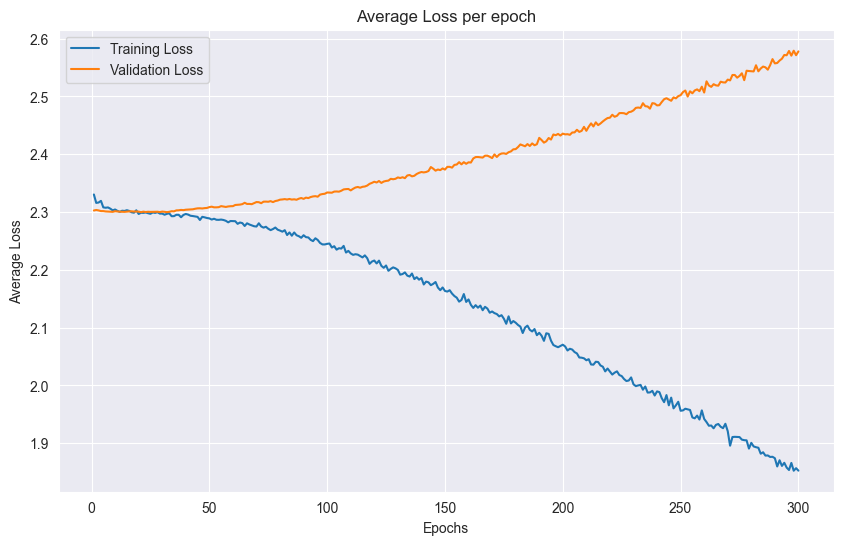

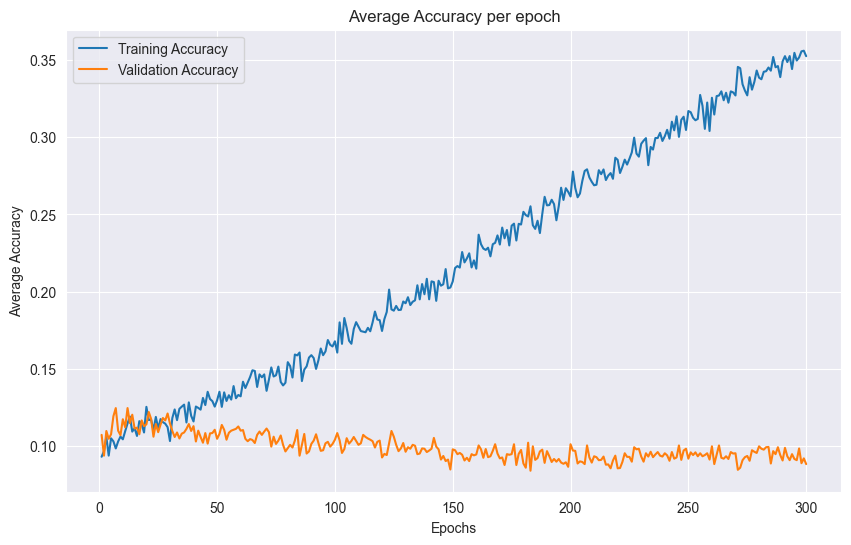

Overall Accuracy: 0.092


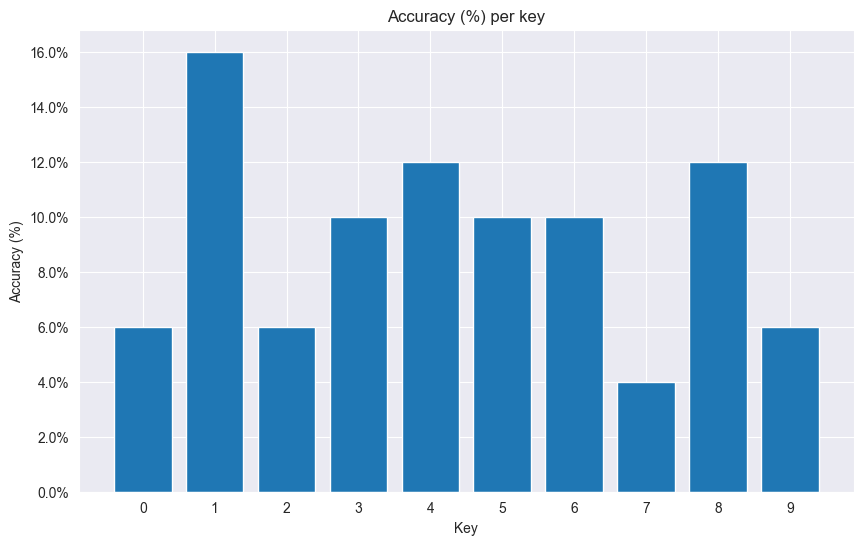

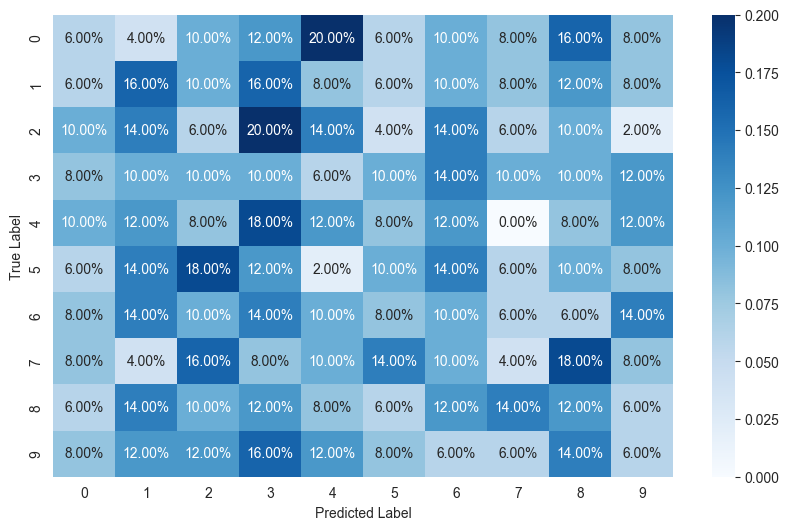

Accuracy for each key: 0: 6.0% 1: 16.0% 2: 6.0% 3: 10.0% 4: 12.0% 5: 10.0% 6: 10.0% 7: 4.0% 8: 12.0% 9: 6.0% 
              precision    recall  f1-score   support

           0       0.08      0.06      0.07        50
           1       0.14      0.16      0.15        50
           2       0.05      0.06      0.06        50
           3       0.07      0.10      0.08        50
           4       0.12      0.12      0.12        50
           5       0.12      0.10      0.11        50
           6       0.09      0.10      0.09        50
           7       0.06      0.04      0.05        50
           8       0.10      0.12      0.11        50
           9       0.07      0.06      0.07        50

    accuracy                           0.09       500
   macro avg       0.09      0.09      0.09       500
weighted avg       0.09      0.09      0.09       500

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 1 * 

In [23]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 300
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
    loss = nn.CrossEntropyLoss()
    
    if (os.path.isfile("model_final.pth")):
        model.load_state_dict(torch.load('model_final.pth'))
    else:
        train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
        # save the model
        torch.save(model.state_dict(), 'model_final.pth')
        plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()